In [2]:
import config.config as cf
import json
import subprocess
from pathlib import Path
import nibabel as nib
import os
import numpy as np
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr


import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

2025-10-13 20:15:23,062 - logger - INFO - Logger initialized


# Data Aggregation

In [5]:
data_200 = {'val': {}, 'test': {}}
data_201 = {'val': {}, 'test': {}}

trainer = "nnUNetTrainer_100epochs__nnUNetResEncUNetMPlans__3d_fullres"

dataset_200_validation = Path(f"{cf.nnunet_trained_models}/{cf.dataset_200}/{trainer}")
dataset_200_test = Path(f"{cf.nnunet_predictions}/{cf.dataset_200}")

dataset_201_validation = Path(f"{cf.nnunet_trained_models}/{cf.dataset_201}/{trainer}")
dataset_201_test = Path(f"{cf.nnunet_predictions}/{cf.dataset_201}")

for i in range(5):
    json_validation_200 = dataset_200_validation / f"fold_{i}/validation/summary.json"
    json_validation_201 = dataset_201_validation / f"fold_{i}/validation/summary.json"
    if json_validation_200.exists():
        with open(json_validation_200) as f:
            data_200["val"][f"fold_{i}"] = json.load(f)

    if json_validation_201.exists():
        with open(json_validation_201) as f:
            data_201["val"][f"fold_{i}"] = json.load(f)

    json_test_200 = dataset_200_test / f"fold_{i}/summary.json"
    json_test_201 = dataset_201_test / f"fold_{i}/summary.json"

    if json_test_200.exists():
        with open(json_test_200) as f:
            data_200["test"][f"fold_{i}"] = json.load(f)

    if json_test_201.exists():
        with open(json_test_201) as f:
            data_201["test"][f"fold_{i}"] = json.load(f)

for sub in ["", "postprocessed"]:
    json_validation_200 = dataset_200_validation / "crossval_results_folds_0_1_2_3_4" / sub / "summary.json"
    json_validation_201 = dataset_201_validation / "crossval_results_folds_0_1_2_3_4" / sub / "summary.json"

    label = "fold_01234_postprocessing" if sub else "fold_01234"
    if json_validation_200.exists():
        with open(json_validation_200) as f:
            data_200["val"][label] = json.load(f)

    if json_validation_201.exists():
        with open(json_validation_201) as f:
            data_201["val"][label] = json.load(f)

for name in ["fold_01234", "fold_01234_postprocessing"]:
    json_test_200 = dataset_200_test / name / "summary.json"
    json_test_201 = dataset_201_test / name / "summary.json"

    if json_test_200.exists():
        with open(json_test_200) as f:
            data_200["test"][name] = json.load(f)

    if json_test_201.exists():
        with open(json_test_201) as f:
            data_201["test"][name] = json.load(f)


In [6]:
map = Path(f"{cf.nnUNet_raw}/{cf.dataset_200}/renaming_history.csv")
df_map = pd.read_csv(map)


def extract_center_and_id(original_id: str):
    centre_str, patient_str = original_id.split("/")
    centre = int(centre_str.split("_")[1])
    patient_id = int(patient_str.split("-")[1])
    return centre, patient_id


patient_mapping = {
    row["New Patient ID"]: {
        "center": extract_center_and_id(row["Original Patient ID"])[0],
        "patient_id": extract_center_and_id(row["Original Patient ID"])[1],
    }
    for _, row in df_map.iterrows()
}

In [7]:
def extract_patient_metrics(data_dict, patient_mapping):
    records = []
    for fold, content in data_dict["test"].items():
        for entry in content.get("metric_per_case", []):
            patient_path = Path(entry["prediction_file"])
            patient_file = patient_path.name.replace(".nii.gz", "")

            metrics = entry["metrics"]["1"]
            meta = patient_mapping.get(patient_file, {"center": None, "patient_id": None})

            records.append(
                {
                    "fold": fold,
                    **meta,
                    **metrics,
                }
            )
    return pd.DataFrame(records)


df_patients_200 = extract_patient_metrics(data_200, patient_mapping)
df_patients_201 = extract_patient_metrics(data_201, patient_mapping)


In [8]:
df_patients_200_nooutlier = df_patients_200[
    ~(
            (df_patients_200["center"] == 7) &
            (df_patients_200["patient_id"] == 8)
    )
]

df_patients_201_nooutlier = df_patients_201[
    ~(
            (df_patients_200["center"] == 7) &
            (df_patients_200["patient_id"] == 8)
    )
]

In [9]:
def extract_foreground_means(data_dict, label, df_patients=None):
    records = []
    for fold, content in data_dict.items():
        fg = content.get("foreground_mean")
        if fg:
            records.append({"dataset": label, "split": "val", "fold": fold, **fg})

    if df_patients is not None:
        grouped = df_patients.groupby("fold").mean().reset_index()
        for _, row in grouped.iterrows():
            records.append({
                "dataset": label,
                "split": "test",
                "fold": row["fold"],
                "Dice": row["Dice"],
                "FN": row["FN"],
                "FP": row["FP"],
                "TN": row["TN"],
                "TP": row["TP"],
                "n_pred": row["n_pred"],
                "n_ref": row["n_ref"],
                "IoU": row["IoU"]
            })

    return pd.DataFrame(records)


df_mean_200 = extract_foreground_means(data_200["val"], "200", df_patients_200_nooutlier)
df_mean_201 = extract_foreground_means(data_201["val"], "201", df_patients_201_nooutlier)


# Latex Tables

In [26]:
def generate_latex_table(df_mean, caption, label):
    row_order = ["fold_0", "fold_1", "fold_2", "fold_3", "fold_4", "fold_01234", "fold_01234_postprocessing"]

    row_labels = {
        "fold_0": "Fold 0",
        "fold_1": "Fold 1",
        "fold_2": "Fold 2",
        "fold_3": "Fold 3",
        "fold_4": "Fold 4",
        "fold_01234": "Fold 0 - 4",
        "fold_01234_postprocessing": "Fold 0 - 4 (Postprocessed)"
    }

    val_dice_max = df_mean.query("split == 'val'")["Dice"].max()
    val_iou_max = df_mean.query("split == 'val'")["IoU"].max()
    test_dice_max = df_mean.query("split == 'test'")["Dice"].max()
    test_iou_max = df_mean.query("split == 'test'")["IoU"].max()

    latex_rows = []
    for row in row_order:
        row_label = row_labels[row]
        val = df_mean.query("split == 'val' and fold == @row")
        test = df_mean.query("split == 'test' and fold == @row")

        def fmt(value, max_val):
            return f"\\textbf{{{value:.4f}}}" if np.isclose(value, max_val) else f"{value:.4f}"

        val_dice_str = fmt(val["Dice"].values[0], val_dice_max) if not val.empty else "-"
        val_iou_str = fmt(val["IoU"].values[0], val_iou_max) if not val.empty else "-"
        test_dice_str = fmt(test["Dice"].values[0], test_dice_max) if not test.empty else "-"
        test_iou_str = fmt(test["IoU"].values[0], test_iou_max) if not test.empty else "-"

        latex_rows.append(f"{row_label} & {val_dice_str} & {val_iou_str} & {test_dice_str} & {test_iou_str} \\\\")

    latex_table = r"""\begin{table}[h!]
\centering
\small
\begin{tabular}{c c c c c}
\toprule
\multirow{2}{*}{\textbf{Evaluation Setup}} & \multicolumn{2}{c}{\textbf{Validation}} & \multicolumn{2}{c}{\textbf{Test}} \\
& \textbf{Dice} & \textbf{IoU} & \textbf{Dice} & \textbf{IoU} \\
\midrule
""" + "\n".join(latex_rows) + r"""
\bottomrule
\end{tabular}
\caption{""" + caption + r"""}
\label{""" + label + r"""}
\end{table}
\FloatBarrier"""
    return latex_table


caption_200 = "Mean segmentation performance across folds for validation and test set (Dice coefficient and IoU) of the MICCAI 2016 challenge dataset without brain extraction and without the outlier patient in the test set (Patient 8 of Center 7)."
label_200 = "tab:msseg2016_200_withskull"
latex_table_200 = generate_latex_table(df_mean_200, caption_200, label_200)

caption_201 = "Mean segmentation performance across folds for validation and test set (Dice coefficient and IoU) of the MICCAI 2016 challenge dataset with brain extraction and without the outlier patient in the test set (Patient 8 of Center 7)."
label_201 = "tab:msseg2016_201_withoutskull"
latex_table_201 = generate_latex_table(df_mean_201, caption_201, label_201)

print(latex_table_200)
print("\n")
print(latex_table_201)

\begin{table}[h!]
\centering
\small
\begin{tabular}{c c c c c}
\toprule
\multirow{2}{*}{\textbf{Evaluation Setup}} & \multicolumn{2}{c}{\textbf{Validation}} & \multicolumn{2}{c}{\textbf{Test}} \\
& \textbf{Dice} & \textbf{IoU} & \textbf{Dice} & \textbf{IoU} \\
\midrule
Fold 0 & 0.7226 & 0.5777 & 0.7186 & 0.5830 \\
Fold 1 & 0.7677 & 0.6261 & 0.7102 & 0.5746 \\
Fold 2 & 0.7856 & 0.6488 & 0.7033 & 0.5667 \\
Fold 3 & \textbf{0.8084} & \textbf{0.6809} & 0.7108 & 0.5768 \\
Fold 4 & 0.6998 & 0.5585 & 0.6891 & 0.5505 \\
Fold 0 - 4 & 0.7568 & 0.6184 & \textbf{0.7271} & \textbf{0.5928} \\
Fold 0 - 4 (Postprocessed) & 0.7568 & 0.6184 & \textbf{0.7271} & \textbf{0.5928} \\
\bottomrule
\end{tabular}
\caption{Mean segmentation performance across folds for validation and test set (Dice coefficient and IoU) of the MICCAI 2016 challenge dataset without brain extraction and without the outlier patient in the test set (Patient 8 of Center 7).}
\label{tab:msseg2016_200_withskull}
\end{table}
\FloatBarrier

# Segmentation Metrics Comparison

In [109]:
# data dense u_net: https://doi.org/10.1016/j.ijmedinf.2022.104965

data_sarica = [
    {"center": "Center 1", "Dice": 0.7069, "Dataset": "Sarica et al. \n (2023)"},
    {"center": "Center 3", "Dice": 0.6360, "Dataset": "Sarica et al. \n (2023)"},
    {"center": "Center 7", "Dice": 0.6916, "Dataset": "Sarica et al. \n (2023)"},
    {"center": "Center 8", "Dice": 0.6564, "Dataset": "Sarica et al. \n (2023)"},
    {"center": "All Centers", "Dice": 0.6727, "Dataset": "Sarica et al. \n (2023)"},
]

df_sarica = pd.DataFrame(data_sarica)

data_best_expert_5 = [
    {"center": "Center 1", "Dice": 0.8038, "Dataset": "Expert 5"},
    {"center": "Center 3", "Dice": 0.8266, "Dataset": "Expert 5"},
    {"center": "Center 7", "Dice": 0.7276, "Dataset": "Expert 5"},
    {"center": "Center 8", "Dice": 0.7733, "Dataset": "Expert 5"},
    {"center": "All Centers", "Dice": 0.7819, "Dataset": "Expert 5"},
]
df_best_expert_5 = pd.DataFrame(data_best_expert_5)

data_best_team_6 = [
    {"center": "Center 1", "Dice": 0.6528, "Dataset": "Team 6"},
    {"center": "Center 3", "Dice": 0.5675, "Dataset": "Team 6"},
    {"center": "Center 7", "Dice": 0.6062, "Dataset": "Team 6"},
    {"center": "Center 8", "Dice": 0.5358, "Dataset": "Team 6"},
    {"center": "All Centers", "Dice": 0.5914, "Dataset": "Team 6"},
]
df_best_team_6 = pd.DataFrame(data_best_team_6)



data_average_expert = [
    {"center": "Center 1", "Dice": 0.7183, "Dataset": "Experts \n Average"},
    {"center": "Center 3", "Dice": 0.7387, "Dataset": "Experts \n Average"},
    {"center": "Center 7", "Dice": 0.6740, "Dataset": "Experts \n Average"},
    {"center": "Center 8", "Dice": 0.7233, "Dataset": "Experts \n Average"},
    {"center": "All Centers", "Dice": 0.7133, "Dataset": "Experts \n Average"},
]
df_average_expert = pd.DataFrame(data_average_expert)

data_average_team = [
    {"center": "Center 1", "Dice": 0.5004, "Dataset": "Teams \n Average"},
    {"center": "Center 3", "Dice": 0.3794, "Dataset": "Teams \n Average"},
    {"center": "Center 7", "Dice": 0.4824, "Dataset": "Teams \n Average"},
    {"center": "Center 8", "Dice": 0.4826, "Dataset": "Teams \n Average"},
    {"center": "All Centers", "Dice": 0.4651, "Dataset": "Teams \n Average"},
]
df_average_team = pd.DataFrame(data_average_team)

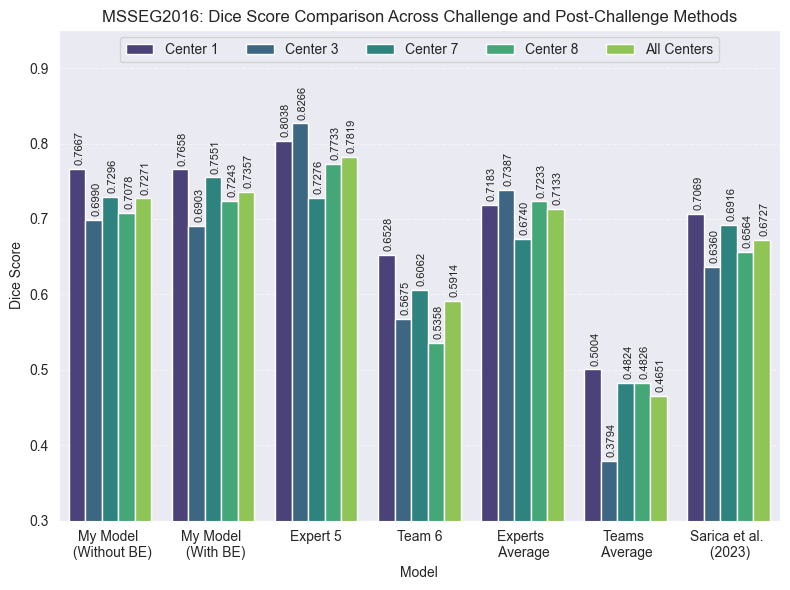

In [100]:
def plot_grouped_bar_by_dataset_and_center(df_patients_200, df_patients_201):
    def prepare_df(df, label, centers_order=[1, 3, 7, 8]):
        center_map = {1: "Center 1", 3: "Center 3", 7: "Center 7", 8: "Center 8"}
        
        df = df.rename(columns={c: c.lower() for c in df.columns})
        
        grouped = df.groupby("center", as_index=False).agg(Dice=("dice", "mean"))
        
        grouped = grouped[grouped["center"].isin(centers_order)]
        
        grouped["center"] = grouped["center"].map(center_map)
        
        grouped["Dataset"] = label
        
        all_centers_row = pd.DataFrame([{
            "center": "All Centers",
            "Dice": df["dice"].mean(),
            "Dataset": label
        }])
        
        return pd.concat([grouped, all_centers_row], ignore_index=True)

    df_mean_per_center_200 = prepare_df(df_patients_200, "My Model \n (Without BE)")
    df_mean_per_center_201 = prepare_df(df_patients_201, "My Model \n (With BE)")

    combined = pd.concat(
        [df_mean_per_center_200, df_mean_per_center_201, df_best_expert_5, df_best_team_6, df_average_expert,
         df_average_team, df_sarica], ignore_index=True)
    combined["center"] = combined["center"].astype(str)

    plt.figure(figsize=(8, 6))
    ax = sns.barplot(
        data=combined,
        x="Dataset",
        y="Dice",
        hue="center",
        palette="viridis",
        dodge=True,
        width=0.8
    )

    for bar in ax.patches:
        height = bar.get_height()
        if not pd.isna(height) and height > 0.01:
            ax.text(
                bar.get_x() + bar.get_width() / 2 + 0.025,
                height + 0.005,
                f"{height:.4f}",
                ha="center", va="bottom", fontsize=8, rotation=90
            )
            
    plt.title("MSSEG2016: Dice Score Comparison Across Challenge and Post-Challenge Methods")
    plt.ylabel("Dice Score")
    plt.xlabel("Model")
    plt.ylim(0.3, 0.95)
    plt.legend(loc="upper center", ncol=5)
    plt.grid(axis="y", linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.savefig("plots/msseg2016_dice_comparison.png", dpi=600, bbox_inches="tight")
    plt.show()

    return df_mean_per_center_200, df_mean_per_center_201

df_metrics_200 = pd.read_csv(Path(f"{cf.nnunet_predictions}/{cf.dataset_200}/fold_01234_postprocessing/metrics/metrics.csv"), delimiter=";")
df_metrics_201 = pd.read_csv(Path(f"{cf.nnunet_predictions}/{cf.dataset_201}/fold_01234_postprocessing/metrics/metrics.csv"), delimiter=";")

df_mean_per_center_200, df_mean_per_center_201 = plot_grouped_bar_by_dataset_and_center(df_metrics_200,
                                                                                        df_metrics_201)


C:\Users\User\AppData\Local\Temp\ipykernel_9328\2866765423.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=plot_df, x="Teams", y="All Centers", palette="viridis")


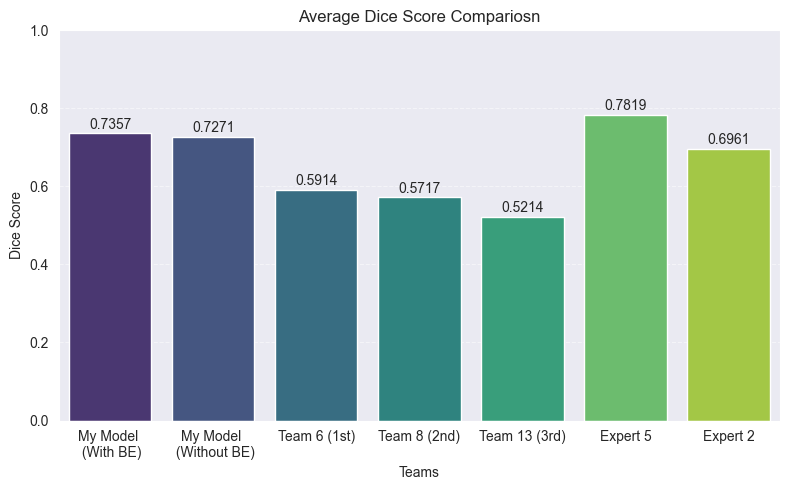

In [4]:

def plot_all_centers_from_list(values, labels, ylabel="Dice Score", title="Average Dice Score Compariosn"):

    plot_df = pd.DataFrame({
        "Teams": labels,
        "All Centers": values
    })
    
    plt.figure(figsize=(8, 5))
    sns.barplot(data=plot_df, x="Teams", y="All Centers", palette="viridis")
    
    ax = plt.gca()
    for i, val in enumerate(values):
        ax.text(i, val + 0.005, f"{val:.4f}", ha="center", va="bottom", fontsize=10)
    
    plt.ylabel(ylabel)
    plt.title(title)
    plt.ylim(0, 1)
    plt.grid(axis="y", linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.savefig("plots/average_dice.png")
    plt.show()


values = [0.7357, 0.7271, 0.5914, 0.5717, 0.5214, 0.7819,0.6961]
labels = [
    "My Model \n (With BE)", 
    "My Model \n (Without BE)", 
    "Team 6 (1st)", 
    "Team 8 (2nd)", 
    "Team 13 (3rd)",
    "Expert 5", 
    "Expert 2"
]

plot_all_centers_from_list(values, labels)

In [101]:
latex_rows = []

dataframes = [
    df_mean_per_center_200,
    df_mean_per_center_201,
    df_best_expert_5,
    df_best_team_6,
    df_average_expert,
    df_average_team,
    df_sarica
]
display_names = [
    r"\begin{tabular}[c]{@{}l@{}}My Model\\ (Without BE)\end{tabular}",
    r"\begin{tabular}[c]{@{}l@{}}My Model\\ (With BE)\end{tabular}",
    r"Expert 5 \cite{commowick_miccai_2018}",
    r"Team 14 \cite{commowick_miccai_2018}",
    r"Experts Average \cite{commowick_miccai_2018}",
    r"Teams Average \cite{commowick_miccai_2018}",
    r"\textcite{sarica_dense_2023}"
]

latex_rows = []
for name, df in zip(display_names, dataframes):
    means = df.groupby("center")["Dice"].mean()

    c1 = means.get("Center 1", float('nan'))
    c3 = means.get("Center 3", float('nan'))
    c7 = means.get("Center 7", float('nan'))
    c8 = means.get("Center 8", float('nan'))
    all_c = means.get("All Centers", float('nan'))

    row = f"{name} & {c1:.4f} & {c3:.4f} & {c7:.4f} & {c8:.4f} & {all_c:.4f} \\\\"
    latex_rows.append(row)

caption = "Dice score comparison across MSSEG2016 centres and models."
label = "tab:dice_centres"

latex_table = r"""\begin{table}[h!]\centering\small
\begin{tabular}{l c c c c c}
\toprule
\textbf{Model} & \textbf{Center 1} & \textbf{Center 3} & \textbf{Center 7} & \textbf{Center 8} & \textbf{All Centers} \\
\midrule
""" + "\n".join(latex_rows) + r"""
\bottomrule
\end{tabular}
\caption{""" + caption + r"""}
\label{""" + label + r"""}
\end{table}
\FloatBarrier"""

print(latex_table)


\begin{table}[h!]\centering\small
\begin{tabular}{l c c c c c}
\toprule
\textbf{Model} & \textbf{Center 1} & \textbf{Center 3} & \textbf{Center 7} & \textbf{Center 8} & \textbf{All Centers} \\
\midrule
\begin{tabular}[c]{@{}l@{}}My Model\\ (Without BE)\end{tabular} & 0.7667 & 0.6990 & 0.7296 & 0.7078 & 0.7271 \\
\begin{tabular}[c]{@{}l@{}}My Model\\ (With BE)\end{tabular} & 0.7658 & 0.6903 & 0.7551 & 0.7243 & 0.7357 \\
Expert 5 \cite{commowick_miccai_2018} & 0.8038 & 0.8266 & 0.7276 & 0.7733 & 0.7819 \\
Team 14 \cite{commowick_miccai_2018} & 0.6528 & 0.5675 & 0.6062 & 0.5358 & 0.5914 \\
Experts Average \cite{commowick_miccai_2018} & 0.7183 & 0.7387 & 0.6740 & 0.7233 & 0.7133 \\
Teams Average \cite{commowick_miccai_2018} & 0.5004 & 0.3794 & 0.4824 & 0.4826 & 0.4651 \\
\textcite{sarica_dense_2023} & 0.7069 & 0.6360 & 0.6916 & 0.6564 & 0.6727 \\
\bottomrule
\end{tabular}
\caption{Dice score comparison across MSSEG2016 centres and models.}
\label{tab:dice_centres}
\end{table}
\FloatBarrier

# Lesion detection evaluation

In [ ]:
def metrics(dataset, fold="fold_01234_postprocessing"):
    pred_dir = Path(f"{cf.nnunet_predictions}/{dataset}/{fold}")
    output_dir_lesion_detection = Path(f"{cf.nnunet_predictions}/{dataset}/{fold}/lesion_detection")
    output_dir_lesion_detection.mkdir(exist_ok=True)
    output_dir_metrics = Path(f"{cf.nnunet_predictions}/{dataset}/{fold}/metrics")
    output_dir_metrics.mkdir(exist_ok=True)

    headers = [
        "Center", "Patient", "Jaccard", "Dice", "Sensitivity", "Specificity", "PPV", "NPV",
        "RelativeVolumeError", "HausdorffDistance", "ContourMeanDistance",
        "SurfaceDistance", "PPVL", "SensL", "F1_score"
    ]
    df = pd.DataFrame(columns=headers)

    for gt_file in Path(f"{cf.nnUNet_raw}/{dataset}/labelsTs").glob("*.nii.gz"):
        patient = gt_file.stem.replace(".nii", "")
        pred_file = pred_dir / f"{patient}.nii.gz"
        patient_id = patient.split("-")[1]
        if not pred_file.exists():
            print(f"Prediction file of {patient} is missing.")
            continue

        center, orig_patient_id = ((lambda d: (d["center"], d["patient_id"]))(
            patient_mapping.get(patient, {"center": None, "patient_id": None})))

        output_prefix = output_dir_lesion_detection / f"Center_{center}_Patient_{orig_patient_id}_lesion_detection.txt"

        img = nib.load(gt_file)
        data = img.get_fdata()
        outlier = np.count_nonzero(data) == 0
        
        if outlier:
            metrics_path = evaluate_lesions(Path(f"{cf.nnUNet_raw}/{dataset}/labelsTs/Patient-43.nii.gz"), pred_file,
                                            output_prefix)
            with open(metrics_path, 'r') as f:
                content = f.read()
        
            parts = content.split('Total number of detections:,')
            detections_part = parts[1].split('Total objects volume:,')[0]
            detections = detections_part.strip()
            with open(metrics_path, 'w') as f:
                f.write(f"Total number of reference objects:,0\n")
                f.write(f"Total number of detections:,{detections}\n")
                f.write(f"Total objects volume:,0\n")
                f.write("Object number,Object volume,Detected flag\n")
        else:
            metrics_path = evaluate_lesions(gt_file, pred_file, output_prefix)

        segperf_path = segperfanalyzer(gt_file, pred_file, output_dir_metrics / "temp")
        if not segperf_path.exists():
            continue

        with open(segperf_path, 'r') as f:
            line = f.read()

        data = line.strip().replace("\t", "").split(";")

        full_row = [center, orig_patient_id] + data[:-3]

        df.loc[len(df)] = full_row

        if segperf_path and segperf_path.exists():
            print(f"{patient_id}: Successful → {segperf_path}")
        else:
            print(f"{patient_id}: Anima Error")

    os.remove(output_dir_metrics / "temp_global.txt")
    df.to_csv(output_dir_metrics / f"metrics.csv", index=False, sep=";")


def evaluate_lesions(gt_path, pred_path, output_prefix, alpha=0.1, beta=0.7, gamma=0.65):
    cmd = [
        "animaDetectedComponents.exe",
        "-o", str(output_prefix),
        "-t", str(pred_path),
        "-r", str(gt_path),
        '-a', str(alpha),
        '-b', str(beta),
        '-g', str(gamma)
    ]

    try:
        subprocess.run(cmd, capture_output=True, text=True)
        return Path(f"{output_prefix}")
    except subprocess.CalledProcessError as e:
        print(f"Error with Anima: {e}")
        return None


def segperfanalyzer(gt_path, pred_path, output_prefix):
    cmd = [
        "animaSegPerfAnalyzer.exe",
        "-d",
        "-l",
        "-s",
        "-t", "8",
        "-o", str(output_prefix),
        "-i", str(pred_path),
        "-r", str(gt_path),
    ]
    print(" ".join(cmd))

    try:
        subprocess.run(cmd)
        return Path(f"{output_prefix}_global.txt")
    except subprocess.CalledProcessError as e:
        print(f"Error with Anima: {e}")
        return None


for i in [1,"01234_postprocessing"]:
    metrics(cf.dataset_200, f"fold_{i}")
    metrics(cf.dataset_201, f"fold_{i}")

lesions = [6, 37, 52, 19, 74, 153, 32, 84, 13, 29, 61, 21, 9, 8, 19, 9, 73, 48, 16, 16, 25, 27, 11, 9, 45, 68, 12, 48,
           8, 14, 80, 4, 129, 44, 5, 140, 99]

lesion_load = [0.3858, 24.4260, 10.7352, 34.6324, 15.5301, 30.1877, 4.3676, 21.6838, 0.5864, 5.0397, 71.6238, 4.1898,
               1.1880, 1.1213, 5.1110, 0.6446, 46.2014, 9.3874, 4.7738, 0.9269, 6.8231, 11.1987, 1.4908, 2.9066, 7.1968,
               15.2173, 11.4763, 19.0200, 1.4501, 0.7843, 29.4715, 0.1240, 15.7995, 26.2669, 1.1831, 17.3809, 8.7936]

for i in [0,1,2,3,4,"01234_postprocessing"]:
    df_200 = pd.read_csv(Path(f"{cf.nnunet_predictions}/{cf.dataset_200}/fold_{i}/metrics/metrics.csv"), delimiter=";")
    df_201 = pd.read_csv(Path(f"{cf.nnunet_predictions}/{cf.dataset_201}/fold_{i}/metrics/metrics.csv"), delimiter=";")
    
    df_200 = df_200[~((df_200["Center"] == 7) &(df_200["Patient"] == 8))]
    df_201 = df_201[~((df_201["Center"] == 7) &(df_201["Patient"] == 8))]

    df_200['Number of lesions'] = lesions
    df_200['Total lesionload'] = lesion_load
    
    df_201['Number of lesions'] = lesions
    df_201['Total lesionload'] = lesion_load
    
    df_200.to_csv(f"{cf.nnunet_predictions}/{cf.dataset_200}/fold_{i}/metrics/metrics.csv", sep=";", index=False)
    df_201.to_csv(f"{cf.nnunet_predictions}/{cf.dataset_201}/fold_{i}/metrics/metrics.csv", sep=";", index=False)

In [76]:

df_metrics_200 = pd.read_csv(Path(f"{cf.nnunet_predictions}/{cf.dataset_200}/fold_01234_postprocessing/metrics/metrics.csv"), delimiter=";")
df_metrics_201 = pd.read_csv(Path(f"{cf.nnunet_predictions}/{cf.dataset_201}/fold_01234_postprocessing/metrics/metrics.csv"), delimiter=";")

In [79]:
np.mean(df_metrics_201["Dice"])

np.float64(0.735667972972973)

In [3]:
df_metrics_201.loc[df_metrics_201["Dice"].idxmin()]

Center                   8.000000
Patient                  5.000000
Jaccard                  0.136618
Dice                     0.240393
Sensitivity              0.840625
Specificity              0.999944
PPV                      0.140250
NPV                      0.999998
RelativeVolumeError    499.375000
HausdorffDistance       93.118100
ContourMeanDistance     29.521318
SurfaceDistance         11.085006
PPVL                     0.333333
SensL                    1.000000
F1_score                 0.500000
Number of lesions        4.000000
Total lesionload         0.124000
Name: 31, dtype: float64

In [14]:
def generate_latex_table(df, caption: str, label: str) -> str:
    segmentation_metrics = ["Jaccard", "Sensitivity", "PPV"]
    lesion_metrics = ["SensL", "PPVL", "F1_score"]
    all_metrics = segmentation_metrics + lesion_metrics

    display_names = {
        "Jaccard": "IoU",
        "Sensitivity": "Sensitivity",
        "PPV": "Precision",
        "SensL": "Sensitivity",
        "PPVL": "PPVL.",
        "F1_score": "F1 Score"
    }

    grouped = df.groupby("Center")[all_metrics].mean().round(4)

    all_centers_mean = df[all_metrics].mean().round(4)
    grouped.loc["All Centers"] = all_centers_mean

    latex_rows = []
    for index, row in grouped.iterrows():
        row_name = f"Center {index}" if index != "All Centers" else "All Centers"
        row_str = row_name + "".join(f" & {row[metric]:.4f}" for metric in all_metrics) + r" \\"
        latex_rows.append(row_str)

    header_line1 = r"\multirow{2}{*}{\textbf{Center}} & \multicolumn{3}{c}{\textbf{Segmentation Metrics}} & \multicolumn{3}{c}{\textbf{Lesion Metrics}} \\"
    header_line2 = " & " + " & ".join([f"\\textbf{{{display_names[m]}}}" for m in all_metrics]) + r" \\"

    latex_table = r"""\begin{table}[h!]
\centering
\small
\begin{tabular}{c c c c c c c}
\toprule
""" + header_line1 + "\n" + header_line2 + r"""
\midrule
""" + "\n".join(latex_rows) + r"""
\bottomrule
\end{tabular}
\caption{""" + caption + r"""}
\label{""" + label + r"""}
\end{table}
\FloatBarrier
"""

    return latex_table

In [ ]:
print(generate_latex_table(df_metrics_200, "", ""))

In [ ]:
print(generate_latex_table(df_metrics_201, "", ""))

# Segmentationperformance per lesion/volume

In [101]:
def plot_metrics_lesion(df):
    fig, axs = plt.subplots(3, 2, figsize=(13, 13))
    metrics = ['Dice', 'F1_score', 'SurfaceDistance']
    x_vals = ['Number of lesions', 'Total lesionload']
    x_labels = ['Number of lesions', 'Total lesion load ($\mathrm{cm}^3$)']
    y_labels = ['Dice score', 'F1Score', 'Average surface distance (mm)']
    subplot_labels = ['a', 'b', 'c', 'd', 'e', 'f']
    
    for i, metric in enumerate(metrics):
        for j, x in enumerate(x_vals):
            ax = axs[i, j]
            idx = i * 2 + j 
            
            x_raw = df[x].replace(0, np.nan)  
            y_raw = df[metric]
            x_log = np.log10(x_raw)
    
            valid = x_log.notna() & y_raw.notna()
            x_clean = x_raw[valid]       
            y_clean = y_raw[valid]
            x_for_fit = x_log[valid]    
    
            ax.scatter(x_clean, y_clean, s=30, alpha=0.8)
    
            model = LinearRegression()
            model.fit(x_for_fit.values.reshape(-1, 1), y_clean.values)
            x_sorted = np.sort(x_clean)
            x_pred = np.log10(x_sorted).reshape(-1, 1)
            y_pred = model.predict(x_pred)
            ax.plot(x_sorted, y_pred, color='red', linewidth=2, label='Regression')
    
            rho_p, _ = pearsonr(x_log, y_clean)
            r2_text = f"$R^2$ = {rho_p ** 2:.4f}"
    
            ax.text(0.95, 0.5,
            r2_text,
            fontsize=10,
            transform=ax.transAxes,
            color='red',
            ha='right', va='center',
            bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))
            
            ax.set_xlabel(x_labels[j], fontsize=11)
            ax.set_ylabel(y_labels[i], fontsize=11)
    
            ax.text(0.5, -0.25, f"({subplot_labels[idx]})", transform=ax.transAxes,
                    ha='center', va='center', fontsize=12, fontweight='bold')
    
    fig.suptitle("Relationship between metric scores (dice, f1 and avg. surface distance) and number of lesions (first column) and total lesion load (second column in $\mathrm{cm}^3$)).", fontsize=14, y=1.02)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.95, hspace=0.4)
    fig.savefig("lesion_metrics_plot.png", bbox_inches="tight")
    plt.show()



<>:9: SyntaxWarning: invalid escape sequence '\m'
<>:60: SyntaxWarning: invalid escape sequence '\m'
<>:9: SyntaxWarning: invalid escape sequence '\m'
<>:60: SyntaxWarning: invalid escape sequence '\m'
C:\Users\User\AppData\Local\Temp\ipykernel_1320\3684683995.py:9: SyntaxWarning: invalid escape sequence '\m'
  x_labels = ['Number of lesions', 'Total lesion load ($\mathrm{cm}^3$)']
C:\Users\User\AppData\Local\Temp\ipykernel_1320\3684683995.py:60: SyntaxWarning: invalid escape sequence '\m'
  fig.suptitle("Relationship between metric scores (dice, f1 and avg. surface distance) and number of lesions (first column) and total lesion load (second column in $\mathrm{cm}^3$)).", fontsize=14, y=1.02)


<>:14: SyntaxWarning: invalid escape sequence '\m'
<>:14: SyntaxWarning: invalid escape sequence '\m'
C:\Users\User\AppData\Local\Temp\ipykernel_1320\774150484.py:14: SyntaxWarning: invalid escape sequence '\m'
  x_labels = ['Number of lesions', 'Total lesion load ($\mathrm{cm}^3$)']


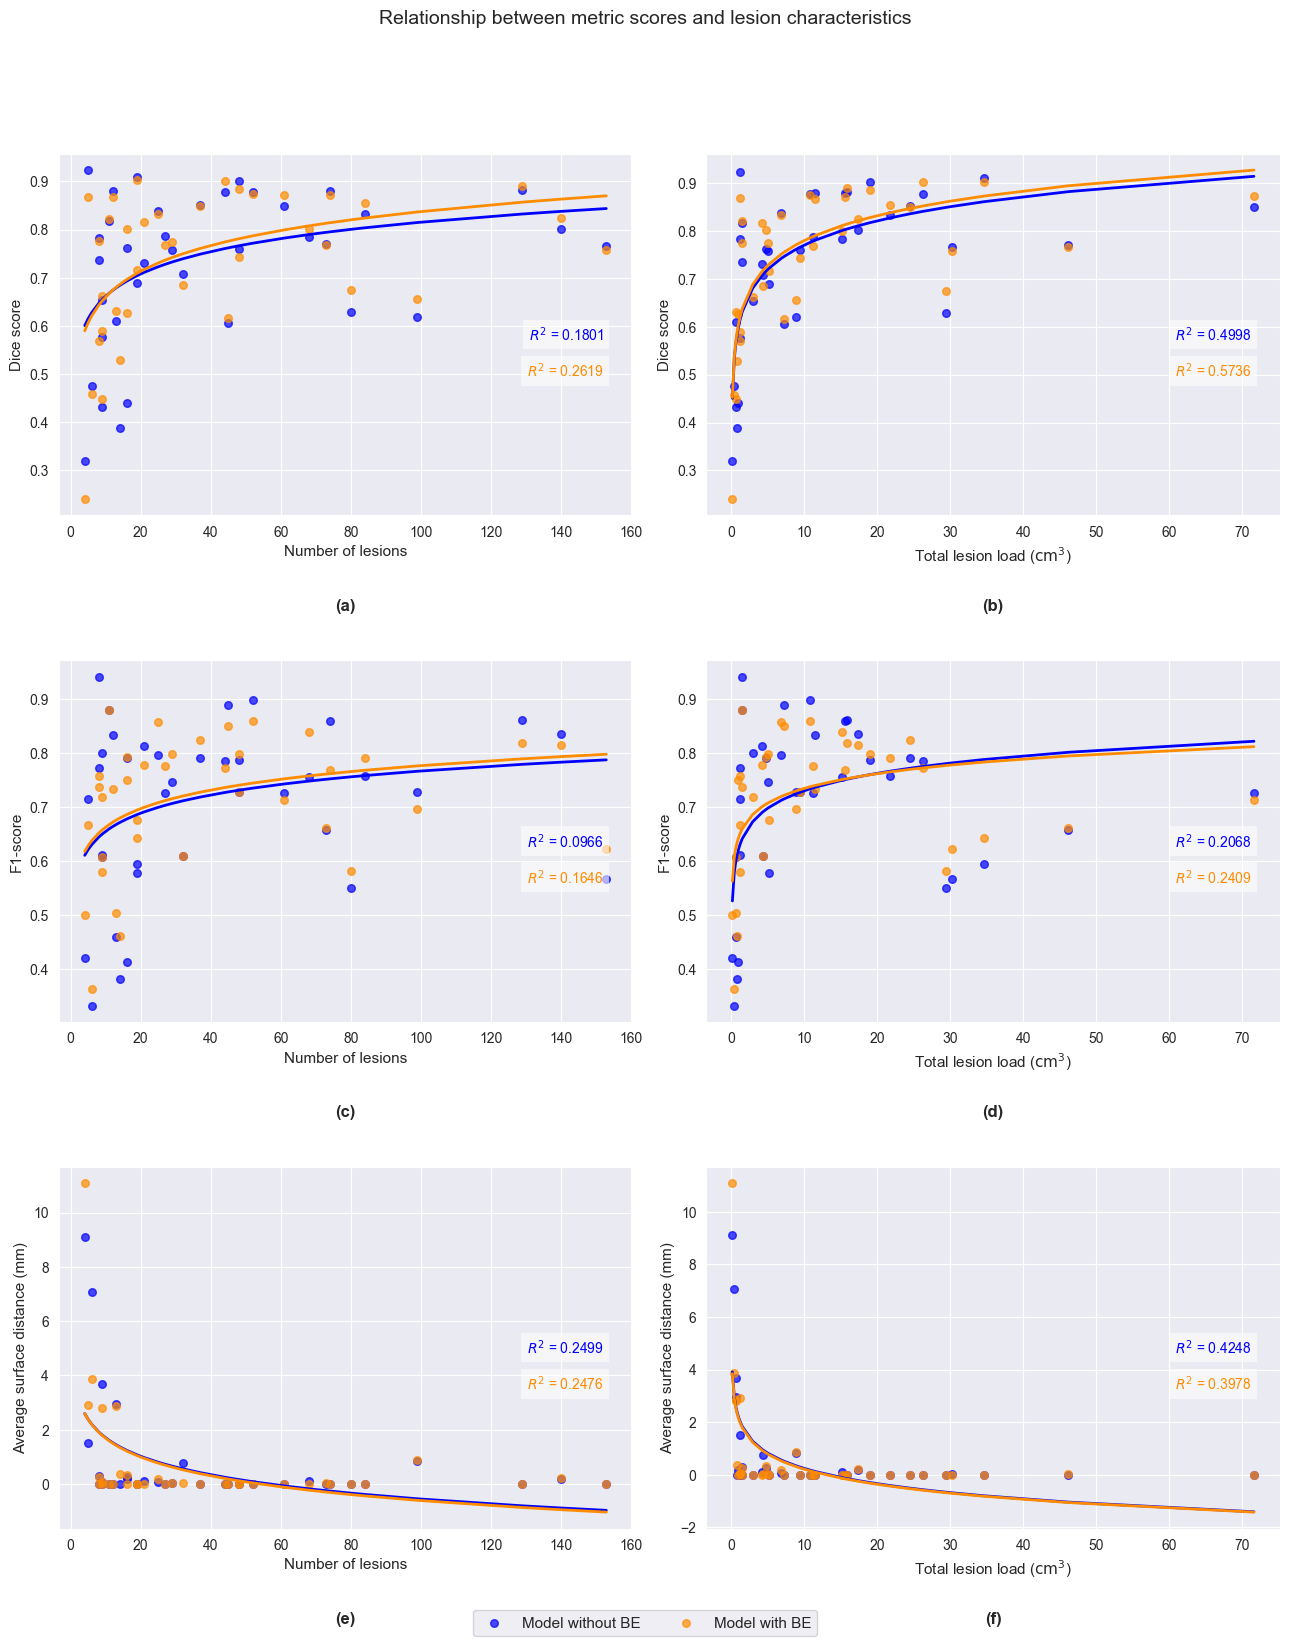

In [115]:
fig, axs = plt.subplots(3, 2, figsize=(13, 16))

metrics = ['Dice', 'F1_score', 'SurfaceDistance']
x_vals = ['Number of lesions', 'Total lesionload']
x_labels = ['Number of lesions', 'Total lesion load ($\mathrm{cm}^3$)']
y_labels = ['Dice score', 'F1-score', 'Average surface distance (mm)']
subplot_labels = ['a', 'b', 'c', 'd', 'e', 'f']

dataframes = [(df_metrics_200, 'blue', 'Model without BE'), (df_metrics_201, 'darkorange', 'Model with BE')]

for i, metric in enumerate(metrics):
    for j, x in enumerate(x_vals):
        ax = axs[i, j]
        idx = i * 2 + j  

        for df, color, label in dataframes:
            x_raw = df[x].replace(0, np.nan)
            y_raw = df[metric]
            x_log = np.log10(x_raw)

            valid = x_log.notna() & y_raw.notna()
            x_clean = x_raw[valid]
            y_clean = y_raw[valid]
            x_for_fit = x_log[valid]

            ax.scatter(x_clean, y_clean, s=30, alpha=0.7, color=color, label=label)

            model = LinearRegression()
            model.fit(x_for_fit.values.reshape(-1, 1), y_clean.values)
            x_sorted = np.sort(x_clean)
            x_pred = np.log10(x_sorted).reshape(-1, 1)
            y_pred = model.predict(x_pred)
            ax.plot(x_sorted, y_pred, color=color, linewidth=2)

            rho_p, _ = pearsonr(x_log, y_clean)
            r2_text = f"$R^2$ = {rho_p ** 2:.4f}"
            ax.text(0.95, 0.5 if label == dataframes[0][2] else 0.4, r2_text,
                    fontsize=10,
                    transform=ax.transAxes,
                    color=color,
                    ha='right', va='center',
                    bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))

        ax.set_xlabel(x_labels[j], fontsize=11)
        ax.set_ylabel(y_labels[i], fontsize=11)

        ax.text(0.5, -0.25, f"({subplot_labels[idx]})", transform=ax.transAxes,
                ha='center', va='center', fontsize=12, fontweight='bold')

handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=2, fontsize=11)

fig.suptitle("Relationship between metric scores and lesion characteristics", fontsize=14, y=1.02)
plt.tight_layout()
plt.subplots_adjust(top=0.93, hspace=0.4)
fig.savefig("lesion_metrics_plot.png", bbox_inches="tight")
plt.show()


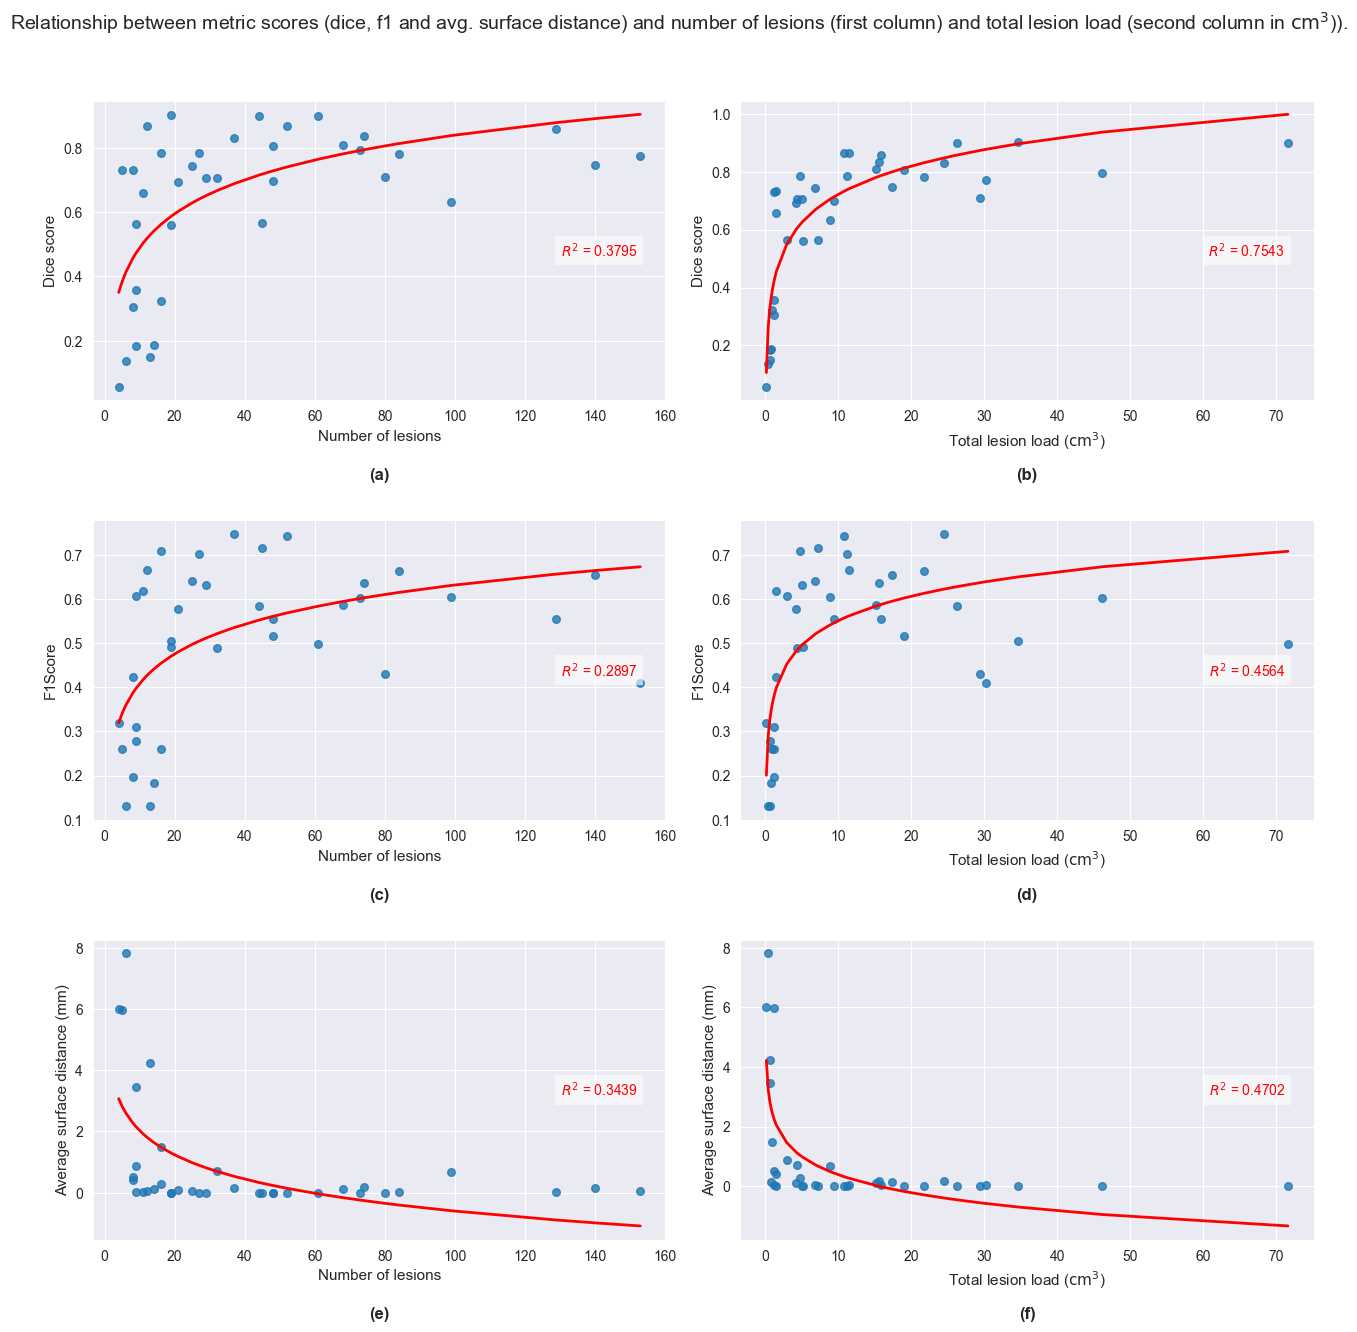

In [116]:
dices = [0.1363, 0.8319, 0.8666, 0.9023, 0.8355, 0.7734, 0.7063, 0.7818, 0.1502, 0.7054, 0.8989, 0.6927, 0.3584, 0.3059,
         0.5595, 0.1845, 0.7944, 0.6981, 0.7850, 0.3232, 0.7443, 0.7854, 0.6584, 0.5645, 0.5650, 0.8091, 0.8667, 0.8073,
         0.7324, 0.1859, 0.7081, 0.0568, 0.8586, 0.8989, 0.7307, 0.7478, 0.6330]

f1_scores = [0.1304, 0.7477, 0.7430, 0.5040, 0.6355, 0.4092, 0.4894, 0.6647, 0.1311, 0.6318, 0.4975, 0.5777, 0.3111,
             0.1967, 0.4924, 0.2793, 0.6026, 0.5556, 0.7097, 0.2609, 0.6400, 0.7018, 0.6186, 0.6061, 0.7163, 0.5868,
             0.6667, 0.5164, 0.4225, 0.1824, 0.4303, 0.3200, 0.5546, 0.5846, 0.2609, 0.6556, 0.6053]

surfaces = [7.8105, 0.1666, 0.0001, 0.0024, 0.1838, 0.0471, 0.7150, 0.0128, 4.2266, 0.0007, 0.0029, 0.0938, 0.0285,
            0.5250, 0.0020, 3.4647, 0.0055, 0.0003, 0.2783, 1.4997, 0.0525, 0.0006, 0.0113, 0.8661, 0.0009, 0.1130,
            0.0407, 0.0005, 0.3992, 0.1333, 0.0000, 6.0102, 0.0343, 0.0001, 5.9724, 0.1371, 0.6681]

lesions = [6, 37, 52, 19, 74, 153, 32, 84, 13, 29, 61, 21, 9, 8, 19, 9, 73, 48, 16, 16, 25, 27, 11, 9, 45, 68, 12, 48,
           8, 14, 80, 4, 129, 44, 5, 140, 99]

lesion_load = [0.3858, 24.4260, 10.7352, 34.6324, 15.5301, 30.1877, 4.3676, 21.6838, 0.5864, 5.0397, 71.6238, 4.1898,
               1.1880, 1.1213, 5.1110, 0.6446, 46.2014, 9.3874, 4.7738, 0.9269, 6.8231, 11.1987, 1.4908, 2.9066, 7.1968,
               15.2173, 11.4763, 19.0200, 1.4501, 0.7843, 29.4715, 0.1240, 15.7995, 26.2669, 1.1831, 17.3809, 8.7936]

df_msseg2016 = pd.DataFrame({
    'Dice': dices,
    'F1_score': f1_scores,
    'SurfaceDistance': surfaces,
    'Number of lesions': lesions,
    'Total lesionload': lesion_load
})

plot_metrics_lesion(df_msseg2016)

# Lesion detection per volume 

In [141]:
def extract_lesion_detection(dataset,fold="fold_01234_postprocessing"):
    path = Path(cf.nnunet_predictions, dataset, fold, "lesion_detection")
    files = path.glob("*.txt")
    
    all_lesions = []
    for file in files:
        if "Center_7" in file.name and "Patient_8" in file.name:
            continue
        
        df = pd.read_csv(file, skiprows=3)
        df.columns = ["Object number", "volume", "detected"]
        parts = file.stem.split("_")
        center = parts[1]
        patient = parts[3]
        
        df["volume"] = df["volume"] / 1000.0
    
        df["center"] = center
        df["patient"] = patient
    
        all_lesions.append(df[["center", "patient", "volume", "detected"]])
    return pd.concat(all_lesions, ignore_index=True)
    
df_all_lesions_200 = extract_lesion_detection(cf.dataset_200)
df_all_lesions_201 = extract_lesion_detection(cf.dataset_201)

<>:31: SyntaxWarning: invalid escape sequence '\m'
<>:31: SyntaxWarning: invalid escape sequence '\m'
C:\Users\User\AppData\Local\Temp\ipykernel_1320\768308229.py:31: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel("Lesion volume ($\mathrm{cm}^3$, log scale)", fontsize=12)


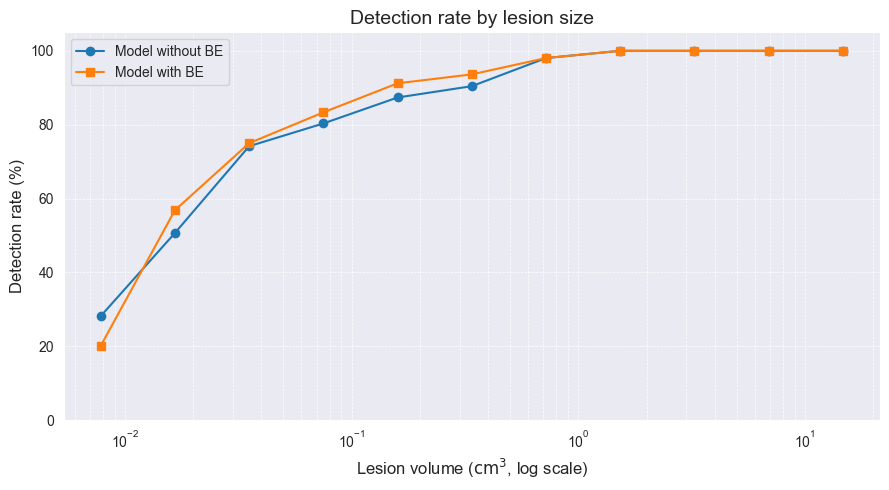

In [144]:

log_bins = np.logspace(np.log10(5 / 1000), np.log10(20000 / 1000), num=12)
bin_centers = (log_bins[:-1] + log_bins[1:]) / 2

def compute_detection_rates(df, bins):
    detection_rates = []
    for i in range(len(bins) - 1):
        bin_mask = (df['volume'] >= bins[i]) & (df['volume'] < bins[i+1])
        n_in_bin = bin_mask.sum()
        if n_in_bin > 0:
            rate = df.loc[bin_mask, 'detected'].sum() / n_in_bin * 100
        else:
            rate = np.nan
        detection_rates.append(rate)
    return detection_rates

rates_200 = compute_detection_rates(df_all_lesions_200, log_bins)
rates_201 = compute_detection_rates(df_all_lesions_201, log_bins)

plt.figure(figsize=(9, 5))
plt.plot(bin_centers, rates_200, marker='o', label='Model without BE', color='tab:blue')
plt.plot(bin_centers, rates_201, marker='s', label='Model with BE', color='tab:orange')

plt.xscale('log')
plt.ylim(0, 105)
plt.xlabel("Lesion volume ($\mathrm{cm}^3$, log scale)", fontsize=12)
plt.ylabel("Detection rate (%)", fontsize=12)
plt.title("Detection rate by lesion size", fontsize=14)
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.savefig("plots/msseg2016_lesion_detection.png")
plt.show()


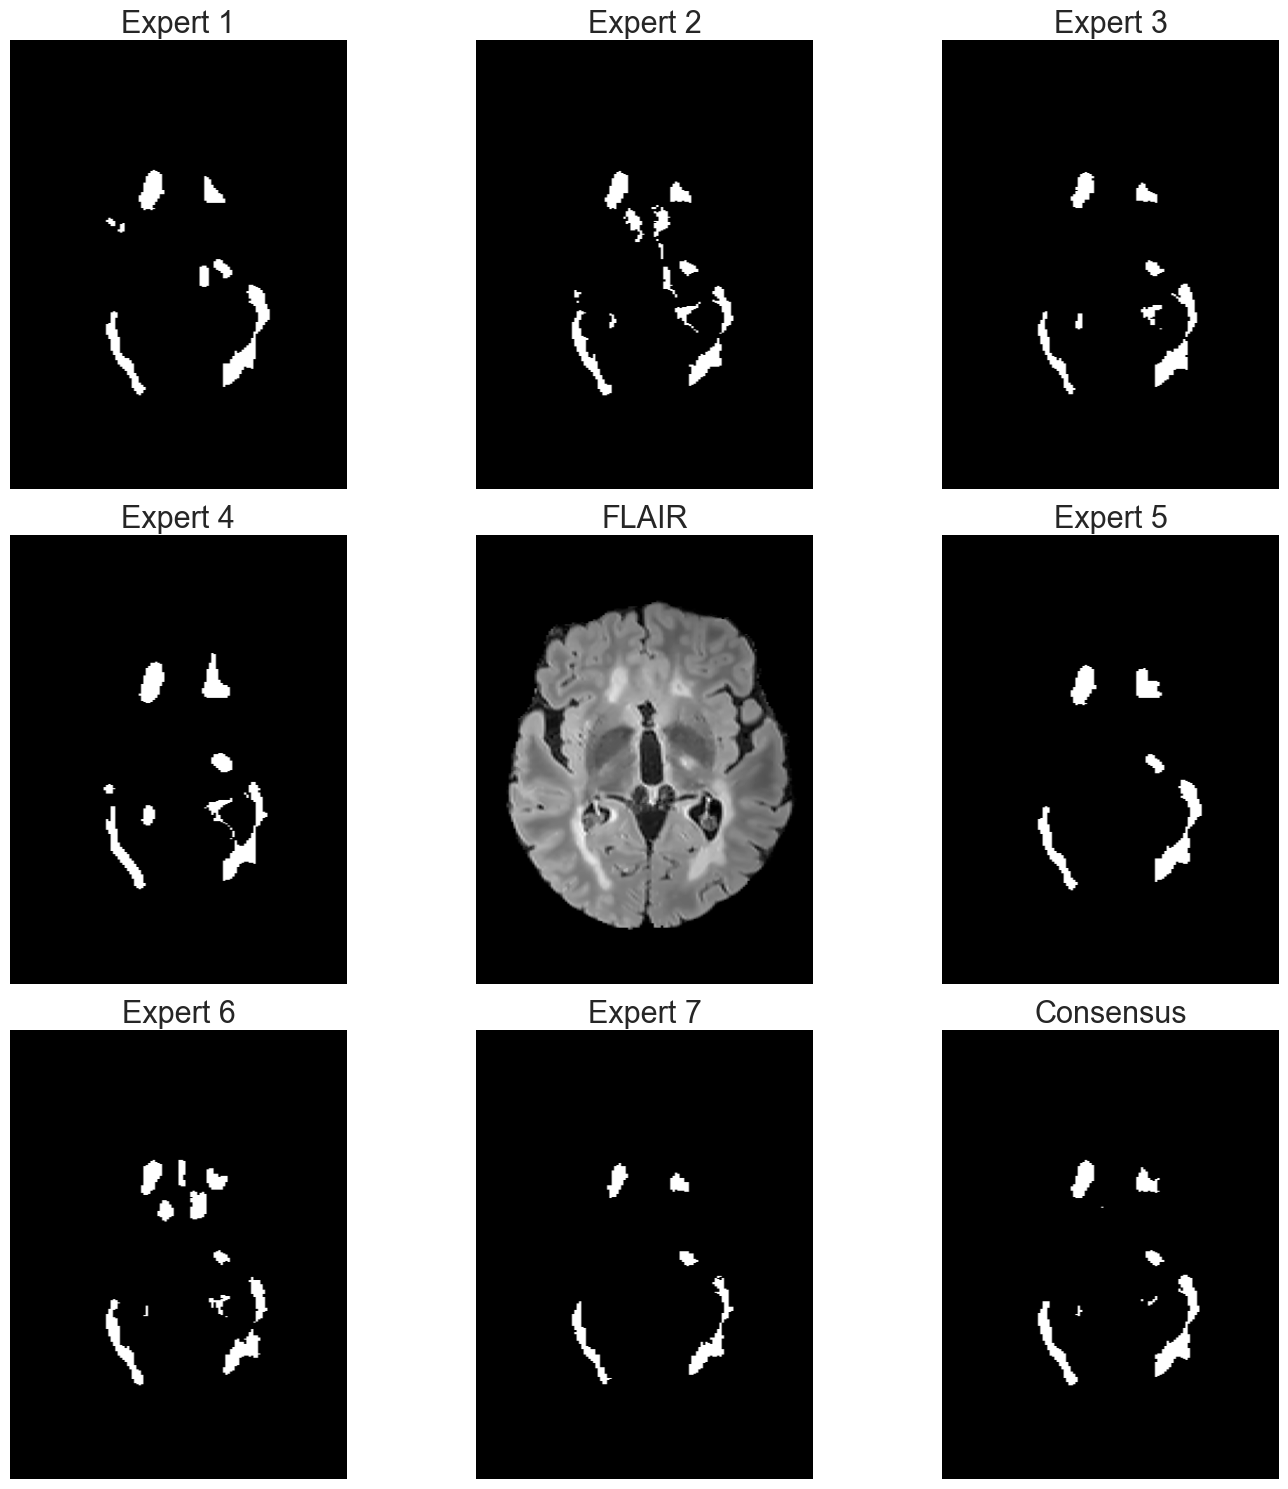

In [3]:

paths = [
    r'C:\Users\User\OneDrive - HTBLA Kaindorf\Bachelorarbeit\data\MSSEG-Training\Training\Center_01\Patient_01\Masks\ManualSegmentation_1.nii.gz',
    r'C:\Users\User\OneDrive - HTBLA Kaindorf\Bachelorarbeit\data\MSSEG-Training\Training\Center_01\Patient_01\Masks\ManualSegmentation_2.nii.gz',    
    r'C:\Users\User\OneDrive - HTBLA Kaindorf\Bachelorarbeit\data\MSSEG-Training\Training\Center_01\Patient_01\Masks\ManualSegmentation_3.nii.gz',
    r'C:\Users\User\OneDrive - HTBLA Kaindorf\Bachelorarbeit\data\MSSEG-Training\Training\Center_01\Patient_01\Masks\ManualSegmentation_4.nii.gz',
    r"C:\Users\User\OneDrive - HTBLA Kaindorf\Bachelorarbeit\data\MSSEG-Training\Training\Center_01\Patient_01\Preprocessed_Data\FLAIR_preprocessed.nii.gz",
    r'C:\Users\User\OneDrive - HTBLA Kaindorf\Bachelorarbeit\data\MSSEG-Training\Training\Center_01\Patient_01\Masks\ManualSegmentation_5.nii.gz',
    r'C:\Users\User\OneDrive - HTBLA Kaindorf\Bachelorarbeit\data\MSSEG-Training\Training\Center_01\Patient_01\Masks\ManualSegmentation_6.nii.gz',
    r'C:\Users\User\OneDrive - HTBLA Kaindorf\Bachelorarbeit\data\MSSEG-Training\Training\Center_01\Patient_01\Masks\ManualSegmentation_7.nii.gz',
    r'C:\Users\User\OneDrive - HTBLA Kaindorf\Bachelorarbeit\data\MSSEG-Training\Training\Center_01\Patient_01\Masks\Consensus.nii.gz',
]

titles = [
    "Expert 1",
    "Expert 2",
    "Expert 3",
    "Expert 4",
    "FLAIR",
    "Expert 5",
    "Expert 6",
    "Expert 7",
    "Consensus"
]
plt.rcParams["axes.titlesize"] = 22 

imgs = [nib.load(p) for p in paths]

crop = (00, 144, 90, 512) 

fig, axes = plt.subplots(3, 3, figsize=(15, 15))
index=0
for i in range(3):
    for j in range(3):
        nii = imgs[index]
    
        mri = nii.get_fdata()
    
        slice_idx = mri.shape[2] // 2 + 50
        slice = mri[:, :, slice_idx]
        
        y1, y2, x1, x2 = crop
        slice = slice[y1:y2, x1:x2]
    
        slice = np.fliplr(slice)
        
        zooms = nii.header.get_zooms()[:2]
        extent = [0, slice.shape[0] * zooms[0], 0, slice.shape[1] * zooms[1]]
    
        flair_slice = slice.T
    
        axes[i, j].imshow(flair_slice, cmap="gray", origin="lower",
                          extent=extent, aspect="equal")
        axes[i, j].set_title(f"{titles[index]}")
        axes[i, j].axis("off")
        
        index +=1

plt.tight_layout()
plt.savefig("plots/msseg_2016_mri_grid.png")
plt.show()